In [46]:
# import libraries test 1
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   
import io
import time
import json
import sagemaker.amazon.common as smac
%matplotlib inline
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance


print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [47]:
# S3 prefix
bucket_name = 'demo-saeed'
prefix = 'fraudcredit-pipeline-boto3'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

In [48]:
!tar -czvf sklearn_fd_featurizer.tar.gz sklearn_fd_featurizer.py

src_path = sagemaker_session.upload_data(
    path='{}'.format('sklearn_fd_featurizer.tar.gz'), 
    bucket=bucket_name,
    key_prefix='{}/{}'.format(prefix, 'src_path'))
print(src_path)

sklearn_fd_featurizer.py
s3://demo-saeed/fraudcredit-pipeline-boto3/src_path/sklearn_fd_featurizer.tar.gz


In [49]:
import datetime
time  = str(datetime.datetime.today()).replace(' ', '-').replace(':', '-').rsplit('.')[0]
training_job_name = 'fd-preprocess-model-job-{}'.format(time)
sm = boto3.client('sagemaker')
resp = sm.create_training_job(
        TrainingJobName = training_job_name, 
        AlgorithmSpecification={
            'TrainingInputMode': 'File',
            'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.20.0-cpu-py3',
        }, 
        RoleArn=role,
        InputDataConfig=[
                            {
                                'ChannelName': 'train',
                                'DataSource': {
                                    'S3DataSource': {
                                        'S3DataType': 'S3Prefix',
                                        'S3Uri': 's3://{}/{}/raw'.format(bucket_name, prefix),
                                        'S3DataDistributionType': 'FullyReplicated',
                                    }
                                },
                            },
                        ], 
        OutputDataConfig={
                            'S3OutputPath': 's3://{}/{}/preprocessed-model'.format(bucket_name, prefix)
                        },
        ResourceConfig={
                        'InstanceType': 'ml.m4.xlarge',
                        'InstanceCount': 1,
                        'VolumeSizeInGB': 30,
                    }, 
        StoppingCondition={
                            'MaxRuntimeInSeconds': 600
                        },
        HyperParameters={
            'sagemaker_program' : "sklearn_fd_featurizer.py",
            'sagemaker_region': "us-east-1",
            'sagemaker_job_name': training_job_name,
            'sagemaker_submit_directory': src_path
        },
        Tags=[]

)

In [51]:
training_job_name

'fd-preprocess-model-job-2019-05-29-04-09-35'

In [50]:
# s3_model_dir = sagemaker.s3_input(s3_data='s3://{}/{}/preprocessed-output/'.format(bucket_name, prefix))
# s3_model_dir.config

In [54]:

sagemaker = boto3.client('sagemaker')
container = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.20.0-cpu-py3'
try:
    sagemaker.create_model(
        ModelName='preprocessing-model2',
        PrimaryContainer={
            'Image': container,
            'ModelDataUrl': 's3://demo-saeed/fraudcredit-pipeline-boto3/preprocessed-model/fd-preprocess-model-job-2019-05-29-04-09-35/output/model.tar.gz',
                'Environment': {
                'SAGEMAKER_PROGRAM': 'sklearn_fd_featurizer.py',
                'SAGEMAKER_REGION':'us-east-1',
                'SAGEMAKER_SUBMIT_DIRECTORY': 's3://demo-saeed/fraudcredit-pipeline-boto3/src_path/sklearn_fd_featurizer.tar.gz'
    
            },
        },
        ExecutionRoleArn=role
    )
except Exception as e:
    print(e)
    print('Unable to create model.')
    raise(e)

In [55]:
sagemaker = boto3.client('sagemaker')
response = sagemaker.create_transform_job(
    TransformJobName='TransformJobName3',
    ModelName='preprocessing-model2',
    MaxConcurrentTransforms=1,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',

    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': 's3://{}/{}/raw'.format(bucket_name, prefix)
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': 's3://{}/{}/transformer_output/'.format(bucket_name, prefix),
        'Accept': 'text/csv',
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    },
    Tags=[]
)

In [36]:
data_location = 's3://{}/{}/transformer_output/{}'.format(bucket_name, prefix,'creditcard.csv.out')
data_location

's3://demo-saeed/fraudcredit-pipeline-boto3/transformer_output/creditcard.csv.out'

In [45]:
data = pd.read_csv(data_location, header=None)
data.head()

FileNotFoundError: demo-saeed/fraudcredit-pipeline-boto3/transformer_output/creditcard.csv.out

In [10]:
X = data.iloc[:, 1:]
y = data.loc[:, 0]

In [11]:
X.shape

(284784, 30)

In [12]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2 ,random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions Validation dataset: ", len(X_val))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_val)+len(X_test))




Number transactions train dataset:  182261
Number transactions Validation dataset:  45566
Number transactions test dataset:  56957
Total number of transactions:  284784


### Upload training set

In [27]:
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_train.values.astype('float32'), y_train.values.reshape(-1).astype('float32'))
f.seek(0)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train','linear_train.data')).upload_fileobj(f)
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix))
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-local/train'}}}

### Upload validation set

In [28]:
f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_val.values.astype('float32'), y_val.values.reshape(-1).astype('float32'))
f.seek(0)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'validation','linear_val.data')).upload_fileobj(f)
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket_name, prefix))
s3_input_validation.config


{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-local/validation'}}}

### Upload test set


In [29]:
test_file = 'linear_test.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, X_test.values.astype('float32'), y_test.values.reshape(-1).astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test',test_file)).upload_fileobj(f)
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test'.format(bucket_name, prefix))
s3_input_test.config

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
   'S3DataType': 'S3Prefix',
   'S3Uri': 's3://demo-saeed/fraudcredit-local/test'}}}

# training

In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [32]:
output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://demo-saeed/fraudcredit-local/output


In [33]:
X_train.shape

(182261, 30)

In [36]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.2xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=30,
                           predictor_type='binary_classifier',
                           epochs = 1,
                           mini_batch_size=200)

linear.fit({'train': s3_input_train,  'validation': s3_input_validation, 'test': s3_input_test})

# train_max_run = 3600,

2019-05-27 18:14:33 Starting - Starting the training job...
2019-05-27 18:14:34 Starting - Launching requested ML instances......
2019-05-27 18:15:41 Starting - Preparing the instances for training...
2019-05-27 18:16:30 Downloading - Downloading input data
2019-05-27 18:16:30 Training - Downloading the training image.....
Docker entrypoint called with argument(s): train
[05/27/2019 18:17:12 INFO 139622264776512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'n

In [48]:
linear._current_job_name

'linear-learner-2019-05-27-18-14-32-796'

In [41]:
linearModel = linear.create_model()


In [45]:
sagemaker = boto3.client('sagemaker')
try:
    sagemaker.create_model(
        ModelName='test1',
        PrimaryContainer={
            'Image': container,
            'ModelDataUrl': 's3://demo-saeed/fraudcredit-local/output/linear-learner-2019-05-27-18-14-32-796/output/model.tar.gz'
        },
        ExecutionRoleArn=role
    )
except Exception as e:
    print(e)
    print('Unable to create model.')
    raise(e)

In [15]:
container_preprocess = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.20.0-cpu-py3'


In [14]:
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [17]:
sagemaker = boto3.client('sagemaker')
response = sagemaker.create_model(
    ModelName='pipline3',
    Containers=[
         {
            'Image': container_preprocess,
            'ModelDataUrl': 's3://sagemaker-us-east-1-079329190341/sagemaker-scikit-learn-2019-05-24-21-46-34-041/output/model.tar.gz',
             'Environment': {
                'SAGEMAKER_PROGRAM': 'sklearn_fd_featurizer.py',
                'SAGEMAKER_REGION':'us-east-1',
                'SAGEMAKER_SUBMIT_DIRECTORY': 's3://sagemaker-us-east-1-079329190341/sagemaker-scikit-learn-2019-05-24-21-46-34-041/source/sourcedir.tar.gz'
    
            },
        },
        {
            'Image': container,
            'ModelDataUrl': 's3://demo-saeed/fraudcredit-local/output/linear-learner-2019-05-27-18-14-32-796/output/model.tar.gz'
        }
    ],
    ExecutionRoleArn=role
)

In [18]:
response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:079329190341:model/pipline3',
 'ResponseMetadata': {'RequestId': '1915559c-7a29-4ca5-ab6e-a7ab7ed2d6d6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1915559c-7a29-4ca5-ab6e-a7ab7ed2d6d6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '70',
   'date': 'Tue, 28 May 2019 16:33:16 GMT'},
  'RetryAttempts': 0}}

In [19]:
try:
        sagemaker.create_endpoint_config(
            EndpointConfigName='scikit-est-model-pipline-3',
            ProductionVariants=[
                {
                    'VariantName': 'prod',
                    'ModelName': 'pipline3',
                    'InitialInstanceCount': 1,
                    'InstanceType': 'ml.c4.xlarge'
                }
            ]
        )
except Exception as e:
        print(e)
        print('Unable to create endpoint configuration.')
        raise(e)

In [21]:
try:
        sagemaker.create_endpoint(
            EndpointName='scikit-est-model-pipe-inference-1',
            EndpointConfigName='scikit-est-model-pipline-3'
        )
except Exception as e:
        print(e)
        print('Unable to create endpoint.')
        raise(e)

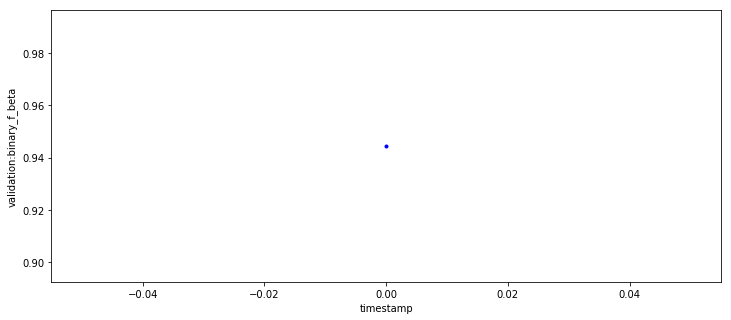

In [201]:
linear.output_path

's3://demo-saeed/fraudcredit-local/output'

In [203]:
#linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name='aws-linear-learner', update_endpoint=True)




In [9]:
xx =X_test.loc[83053]

NameError: name 'X_test' is not defined

In [8]:
X_test

NameError: name 'X_test' is not defined

In [10]:
X_test.loc[83053].values

NameError: name 'X_test' is not defined

In [231]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer
#linear_predictor.predict(X_test.iloc[0])

linear_predictor.predict(X_test.loc[83053])

{'predictions': [{'score': 0.9563339948654175, 'predicted_label': 1.0}]}

'aws-linear-learner'

In [209]:
input_Data = ",".join( map( str, X_test.iloc[0] ) )
input_Data

import io
import boto3
import json
import csv

# grab environment variables
ENDPOINT_NAME = 'aws-linear-learner'
runtime= boto3.client('runtime.sagemaker')

input_Data = ",".join( map( str, X_test.iloc[0] ) )
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                   ContentType='text/csv',
                                   Body=input_Data)
print(response)
result = json.loads(response['Body'].read().decode())
print(result)


{'ResponseMetadata': {'RequestId': 'c4f995d6-db76-4473-bbb3-02254f7a4491', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c4f995d6-db76-4473-bbb3-02254f7a4491', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Wed, 22 May 2019 13:47:03 GMT', 'content-type': 'application/json', 'content-length': '73'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7ff5d6227908>}
{'predictions': [{'score': 0.11748139560222626, 'predicted_label': 0.0}]}
